In [106]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 10000
n_features = 10
n_treatments = 1
n_outputs = 1
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, 1, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
# for t in range(n_treatments):
#     T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0] + U[:, 0] + Z[:, t]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 2*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

# Ensemble Estimator fit

In [107]:
from econml.tree import Tree
from econml.grf import LinearMomentGRFCriterionMSE, LinearMomentGRFCriterion
from econml.tree import BestSplitter
from econml.tree import DepthFirstTreeBuilder
from sklearn.model_selection import train_test_split
import numpy as np


def fit(X, y, n_features, n_outputs, random_state, 
        criterion='het',
        max_depth = 100,
        min_samples_leaf = 100,
        min_balancedness_tol = .3,
        min_impurity_decrease=-np.inf, 
        subsample_fr=.7, replace=False, 
        honest=True):
    min_samples_split = 2
    min_weight_leaf = 0
    max_features = n_features
    n_outputs = n_outputs
    n_samples = X.shape[0]

    random_state = np.random.RandomState(random_state)
    inds = random_state.choice(X.shape[0], int(np.ceil(subsample_fr * X.shape[0])), replace=replace)
    sample_weight = np.zeros(X.shape[0])
    sample_weight[inds] = 1

    if honest:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = train_test_split(X, y, sample_weight,
                                                                                            np.arange(X.shape[0]),
                                                                                            train_size=.5,
                                                                                            random_state=random_state)
    else:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = X, X, y, y, sample_weight, sample_weight,\
            np.arange(X.shape[0]), np.arange(X.shape[0])
    tree = Tree(n_features, n_outputs, store_jac=True)
    if criterion == 'het':
        criterion = LinearMomentGRFCriterion(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    else:
        criterion = LinearMomentGRFCriterionMSE(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    splitter = BestSplitter(criterion, max_features, min_samples_leaf, min_weight_leaf,
                            min_balancedness_tol, random_state)
    builder = DepthFirstTreeBuilder(splitter, min_samples_split, min_samples_leaf, min_weight_leaf,
                                    max_depth, min_impurity_decrease)
    builder.build(tree, Xtrain, ytrain, Xval, yval, n_features,
                  sample_weight=sample_weight_train, sample_weight_val=sample_weight_val, store_jac=True)
    if honest:
        sample_weight[inds_train] = 0
    return tree, sample_weight

# Fitting without Instrument

In [108]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Taug
pointJ = cross_product(Taug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='het',
                                 max_depth = 10,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease=0,
                                 subsample_fr=.7, replace=False, honest=True) for _ in range(100))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


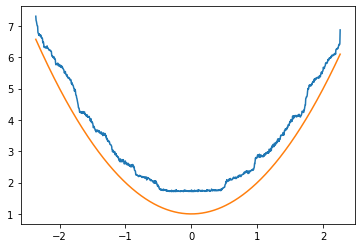

In [109]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest), axis=0)[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [110]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


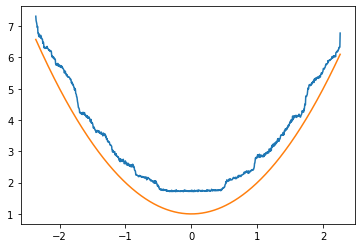

In [111]:
###### import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

# Fitting with Instrument

In [128]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
Zaug = np.hstack([Z, np.ones((Z.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Zaug
pointJ = cross_product(Zaug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(1233)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='mse',
                                 max_depth = 100,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease = -np.inf,
                                 subsample_fr=.9, replace=False, honest=True) for _ in range(1000))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


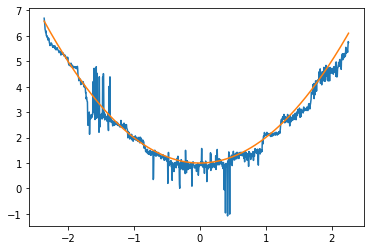

In [129]:
import matplotlib.pyplot as plt
pred_test_point = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                                                                              for tree, _ in forest), axis=0)
plt.plot(X_test[:, 0], pred_test_point[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [114]:
np.unique(np.concatenate([tree.feature for tree, _ in forest]), return_counts=True)

(array([-2,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64),
 array([5030, 3455,  110,   55,   67,   56,   86,   53,   48,   62,   38],
       dtype=int64))

In [115]:
np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


array([0.96790157, 0.00611957, 0.00267065, 0.00370871, 0.00326137,
       0.005395  , 0.0030197 , 0.00242756, 0.00371522, 0.00178065])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


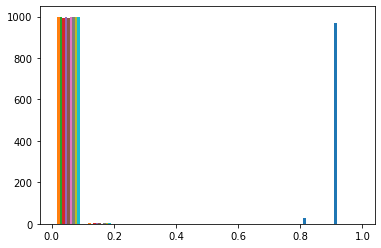

In [116]:
plt.hist(np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest)))
plt.show()

In [117]:
np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_heterogeneity_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


array([ 1.00080750e+00, -9.47309930e-04,  4.15448280e-04,  6.42628149e-05,
       -1.62718276e-04,  2.50351524e-05,  2.86576111e-05, -2.24327021e-04,
        4.29427479e-04, -4.35974247e-04])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


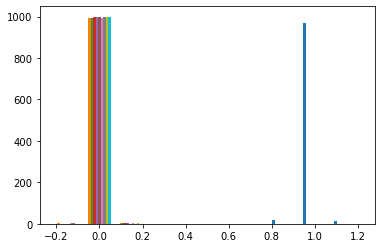

In [118]:
plt.hist(np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_heterogeneity_importances)(normalize=True) for tree, _ in forest)))
plt.show()

In [119]:
forest[0][0].impurity[:10]

array([10.90603732, 23.45630146, 44.00681133, 29.91856191, 19.90892841,
        2.65049415,  3.74712091,  3.59929835,  7.43362513])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


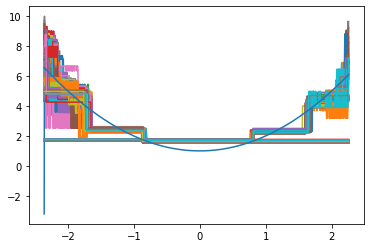

In [120]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 0].T)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

### Inverse of average Jacobian instead of average of inverses

In [130]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


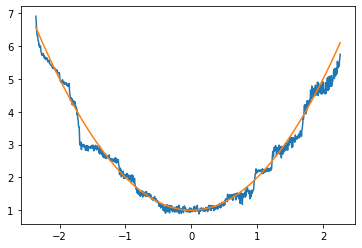

In [131]:
###### import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [133]:
from econml.utilities import cross_product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


Taug = np.hstack([cross_product(X, T), T, np.ones((T.shape[0], 1))])
Zaug = np.hstack([cross_product(X, Z), Z, np.ones((Z.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Zaug
lambda_reg = n_features * 1
penalty = np.zeros(Taug.shape[1])
penalty[:n_features*n_treatments] = 1
penalty = np.diag(penalty)
pointJ = cross_product(Zaug, Taug)

def local_linear_params(tree, X, alpha, pointJ, sample_weight):
    mask = sample_weight > 0
    X, alpha, pointJ = X[mask], alpha[mask], pointJ[mask]
    encoder = LabelEncoder()
    leafs = encoder.fit_transform(tree.apply(X))
    leafs_ohe = OneHotEncoder(sparse=False).fit_transform(leafs.reshape(-1, 1))
    leafs_size = np.sum(leafs_ohe, axis=0)
    leaf_penalty = (penalty.reshape(1, -1) * 
                    (lambda_reg / np.sqrt(leafs_size)).reshape(-1, 1)).reshape(-1, n_outputs, n_outputs)
    leaf_pointJ = np.mean(cross_product(pointJ, leafs_ohe), axis=0).reshape(-1, n_outputs, n_outputs)
    leaf_alpha = np.mean(cross_product(alpha, leafs_ohe), axis=0).reshape(-1, n_outputs)
    leaf_param = np.einsum('ijk,ik->ij', np.linalg.pinv(leaf_pointJ + leaf_penalty), leaf_alpha)
    return tree, encoder, leaf_param, leaf_alpha, leaf_pointJ + leaf_penalty

res = Parallel(n_jobs=-1, backend='loky', verbose=1)(
    delayed(local_linear_params)(tree, X, alpha, pointJ, sample_weight)
                 for tree, sample_weight in forest)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.2min finished


In [134]:
def local_linear_predict(X_test, tree, encoder, leaf_param, n_treatments):
    pred_test = np.zeros((X_test.shape[0], n_treatments))
    all_params = leaf_param[encoder.transform(tree.apply(X_test))]
    for t in range(n_treatments):
        start = t * n_features
        end = start + n_features
        params_test = all_params[:, start:end]
        params_test = np.hstack([params_test, all_params[:, [n_features * n_treatments + t]]])
        pred_test[:, t] = np.sum(params_test * np.hstack([X_test, np.ones((X_test.shape[0], 1))]), axis=1)
    return pred_test

pred_test = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
                delayed(local_linear_predict)(X_test, tree, encoder, leaf_param, n_treatments)
                 for tree, encoder, leaf_param, _, _ in res), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


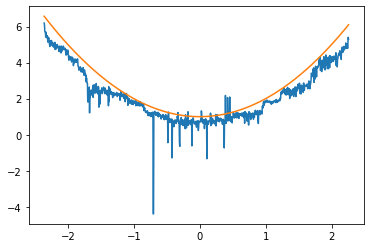

In [135]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [136]:
def local_linear_alpha_predict(X_test, tree, encoder, leaf_alpha):
    leafs_test = encoder.transform(tree.apply(X_test))
    return leaf_alpha[leafs_test]

def local_linear_grad_predict(X_test, tree, encoder, leaf_grads):
    leafs_test = encoder.transform(tree.apply(X_test))
    return leaf_grads[leafs_test]

alphas = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
                delayed(local_linear_alpha_predict)(X_test, tree, encoder, leaf_alpha)
                 for tree, encoder, _, leaf_alpha, _ in res), axis=0)

grads = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
                delayed(local_linear_grad_predict)(X_test, tree, encoder, leaf_grads)
                 for tree, encoder, _, _, leaf_grads in res), axis=0)
all_params = np.einsum('ijk,ik->ij', np.linalg.pinv(grads), alphas)
pred_test = np.zeros((X_test.shape[0], n_treatments))
for t in range(n_treatments):
    start = t * n_features
    end = start + n_features
    params_test = all_params[:, start:end]
    params_test = np.hstack([params_test, all_params[:, [n_features * n_treatments + t]]])
    pred_test[:, t] = np.sum(params_test * np.hstack([X_test, np.ones((X_test.shape[0], 1))]), axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


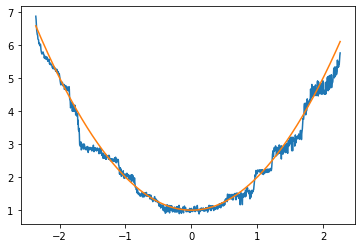

In [137]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()